# Using a Denoising Autoencoder to Generate Images

This notebook loads a UNet that was previously trained in the companion notebook. The UNet is first applied to denoise MNIST test images. Then it is applied to generate images via a diffusion/Langevin dynamics.

Diffusion/Langevin dynamics as described in [Generative Modeling by Estimating Gradients of the Data Distribution](https://arxiv.org/abs/1907.05600)

The UNet is assumed to be trained using Technique 3 in [Improved Techniques for Training Score-Based Generative Models](https://arxiv.org/abs/2006.09011).\
I.e. the UNet is trained to predict the unscaled noise, which the paper says removes the need to make the net noise-conditional.

## Setup ##

In [ ]:
# imports
import torch
from torch import nn, optim
import torch.nn.functional as F

# import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader

import numpy as np
import random

import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = False
plt.rcParams['image.cmap'] = 'gray'

from IPython import display

from google.colab import drive

batch_size = 8

## Variant of InstanceNorm that lets through some DC signal.
Modified from https://github.com/ermongroup/ncsn

In [ ]:
class InstanceNorm2dPlus(nn.Module):
    def __init__(self, num_features, bias=True):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=False, track_running_stats=False)
        self.alpha = nn.Parameter(torch.zeros(num_features))
        self.gamma = nn.Parameter(torch.zeros(num_features))
        self.alpha.data.normal_(1, 0.02)
        self.gamma.data.normal_(1, 0.02)
        if bias:
            self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        means = torch.mean(x, dim=(2, 3))
        m = torch.mean(means, dim=-1, keepdim=True)
        v = torch.var(means, dim=-1, keepdim=True)
        means = (means - m) / (torch.sqrt(v + 1e-5))
        h = self.instance_norm(x)

        if self.bias:
            h = h + means[..., None, None] * self.alpha[..., None, None]
            out = self.gamma.view(-1, self.num_features, 1, 1) * h + self.beta.view(-1, self.num_features, 1, 1)
        else:
            h = h + means[..., None, None] * self.alpha[..., None, None]
            out = self.gamma.view(-1, self.num_features, 1, 1) * h
        return out

## Create UNet ##


In [ ]:
## Your UNet code here
# helper operations
def conv3x3(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels,
        kernel_size=3, stride=1, padding=1, bias=True)

def maxpool2x2():
    return nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

class UpConv2x2(nn.Module):
    def __init__(self, channels):
        super(UpConv2x2, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv = nn.Conv2d(channels, channels // 2,
            kernel_size=2, stride=1, padding=0, bias=True)

    def forward(self, x):
        x = self.upsample(x)
        x = F.pad(x, (0,1,0,1))
        x = self.conv(x)
        return x

def concat(xh, xv):
    return torch.cat([xh, xv], dim=1)


# unet blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(ConvBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = conv3x3(out_channels, out_channels)
        self.insta1 = InstanceNorm2dPlus(out_channels)
        self.insta2 = InstanceNorm2dPlus(out_channels)
        self.relu2 = nn.ReLU()


    def forward(self, x):
        x = self.conv1(x)
        x = self.insta1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.insta2(x)
        x = self.relu2(x)
        return x

class DownConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(DownConvBlock, self).__init__()

        self.downsample = maxpool2x2()
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.downsample(x)
        x = self.conv(x)

        return x

class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(UpConvBlock, self).__init__()

        self.up = UpConv2x2(in_channels)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, xh, xv):
        """
        Args:
            xv: torch Variable, activations from same resolution feature maps (gray arrow in diagram)
            xh: torch Variable, activations from lower resolution feature maps (green arrow in diagram)
        """
        x = self.up(xh)
        x = concat(x, xv)
        x = self.conv(x)

        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        fs = [16,32,64,128,256]
        self.conv_in = ConvBlock(1, fs[0])
        self.dconv1 = DownConvBlock(fs[0], fs[1])
        self.dconv2 = DownConvBlock(fs[1], fs[2])
        self.dconv3 = DownConvBlock(fs[2], fs[3])
        self.dconv4 = DownConvBlock(fs[3], fs[4])
        self.uconv1 = UpConvBlock(fs[4], fs[3])
        self.uconv2 = UpConvBlock(fs[3], fs[2])
        self.uconv3 = UpConvBlock(fs[2], fs[1])
        self.uconv4 = UpConvBlock(fs[1], fs[0])
        self.conv_out = conv3x3(fs[0], 1)

    def forward(self, x):
        x1 = self.conv_in(x)
        x2 = self.dconv1(x1)
        x3 = self.dconv2(x2)
        x4 = self.dconv3(x3)
        x5 = self.dconv4(x4)
        x = self.uconv1(x5, x4)
        x = self.uconv2(x, x3)
        x = self.uconv3(x, x2)
        x = self.uconv4(x, x1)
        x = self.conv_out(x)

        return x


## Load model

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
net = UNet()
net.load_state_dict(torch.load('gdrive/MyDrive/testnoaugment'))
net.cuda()

UNet(
  (conv_in): ConvBlock(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (insta1): InstanceNorm2dPlus(
      (instance_norm): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (insta2): InstanceNorm2dPlus(
      (instance_norm): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (relu2): ReLU()
  )
  (dconv1): DownConvBlock(
    (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): ConvBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU()
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (insta1): InstanceNorm2dPlus(
        (instance_norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)


## Visualize denoising performance on MNIST test images

#### helper function to convert torch tensor to numpy array for visualization


In [ ]:
def var2np(arr):
    return arr.squeeze().detach().cpu().numpy()

#### MNIST test images (not used in training)

In [ ]:
batch_size=8

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.ToTensor()   # floating point, normalized to range [0, 1]
)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
testset = iter(test_dataloader)

#### Geometric sequence for noise levels

Text(0.5, 1.0, 'geometric sequence of noise scales')

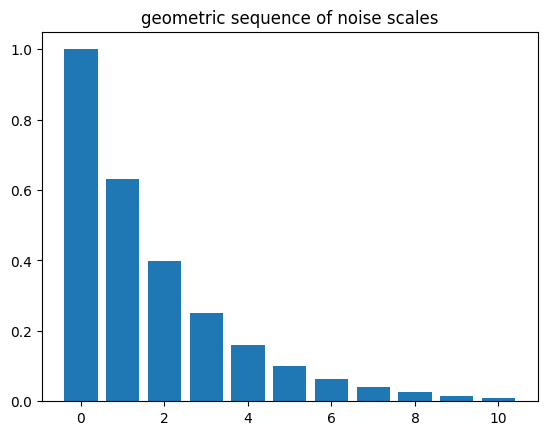

In [ ]:
gamma = (0.01)**0.1
sigma = [gamma**i for i in range(11)]
plt.bar(range(11), sigma)
plt.title('geometric sequence of noise scales')

#### Add noise to batch of test images, using a different noise scale for each image

In [ ]:
(X, y) = next(testset)
X = F.pad(X, (2,2,2,2))
X -= 0.5

noise = torch.randn(X.shape)
scale = torch.tensor(sigma[:batch_size])
scale = scale.unsqueeze(1).unsqueeze(2).unsqueeze(3)
noisy = X + scale*noise

#### Denoise the batch using the UNet

In [ ]:
if torch.cuda.is_available():
  X = X.cuda()
  scale = scale.cuda()
  noisy = noisy.cuda()

pred = net(noisy)
denoised = noisy + scale*pred

#### Compare original, noisy, and denoised images

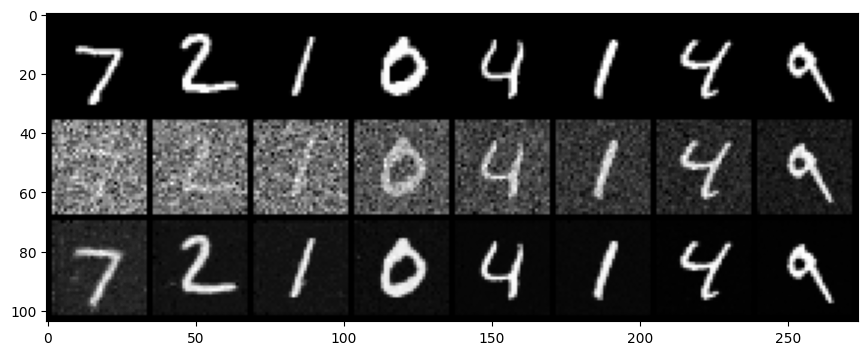

In [ ]:
plt.figure(figsize=(12, 4))
plt.imshow(var2np(make_grid(torch.cat((X, noisy, denoised), 0), normalize=True, scale_each=True)[1, :, :]))

## Generate by diffusion/Langevin dynamics

#### Initialize with noise

In [ ]:
X = torch.rand((batch_size, 1, 32, 32)) - 0.5
X = X.cuda()
alpha = 0.1
beta = np.sqrt(2*alpha)

#### diffusion/Langevin dynamics for sampling

In [ ]:
XX = []
with torch.no_grad():
  for l in range(11):
    for t in range(100):
      XX.append(X.clone())
      pred = net(X)
      X += sigma[l]*(alpha*pred + beta*torch.randn(pred.shape).cuda())
  X += sigma[l]*pred

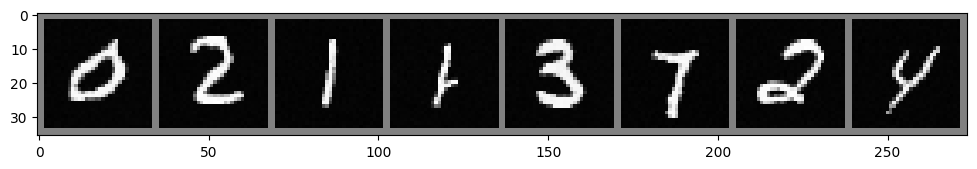

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(var2np(make_grid(X)[1, :, :]))

#### Replay the Langevin dynamics for a single image

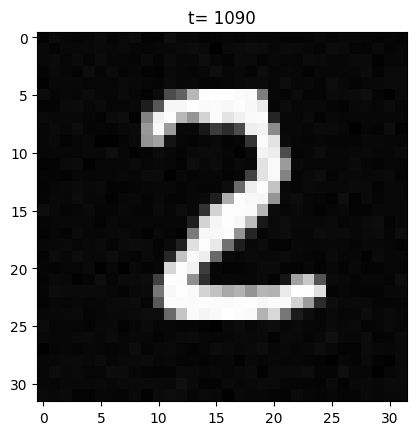

<Figure size 640x480 with 0 Axes>

In [ ]:
ibatch = 1
for t in range(0, 1100, 10):    # display every 10 time steps
  plt.imshow(var2np(XX[t][ibatch, 0, :, :]))
  plt.title("t= {}".format(t))
  display.clear_output(wait=True)
  display.display(plt.gcf())
  plt.clf()

Zeroing out noise

In [ ]:
X = torch.rand((batch_size, 1, 32, 32)) - 0.5
X = X.cuda()
alpha = 0.1
beta = 0

XX = []
with torch.no_grad():
  for l in range(11):
    for t in range(100):
      XX.append(X.clone())
      pred = net(X)
      X += sigma[l]*(alpha*pred + beta*torch.randn(pred.shape).cuda())
  X += sigma[l]*pred

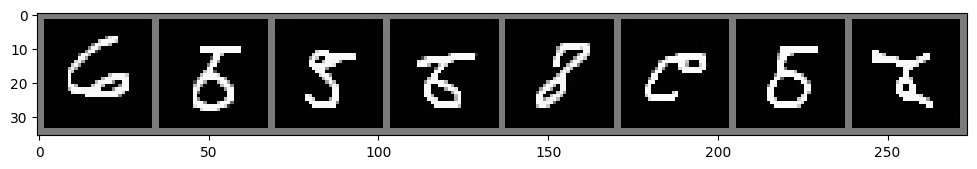

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(var2np(make_grid(X)[1, :, :]))

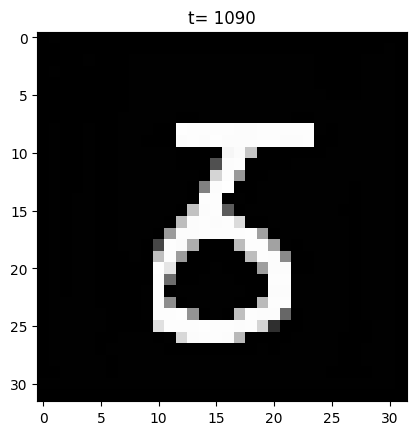

<Figure size 640x480 with 0 Axes>

In [ ]:
ibatch = 1
for t in range(0, 1100, 10):    # display every 10 time steps
  plt.imshow(var2np(XX[t][ibatch, 0, :, :]))
  plt.title("t= {}".format(t))
  display.clear_output(wait=True)
  display.display(plt.gcf())
  plt.clf()